In [2]:
import pandas as pd
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc as pm
import arviz as az
import pandas as pd
import scipy.linalg as la
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import json
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
az.style.use('arviz-darkgrid')
#os.chdir('/Users/noahdunn/Desktop/MSDS/DS6040/Project')

/Users/alseekford/opt/anaconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
df = pd.read_csv('Use_This.csv')

In [4]:
df.head()

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,player_name,position,team,opponent,teamscore,opponentscore,date,avg_pts
0,5038,202101200TOR,achiupr01,0,14:24,0,0,12.8,Precious Achiuwa,F,TOR,MIA,102,111,120,12.800000
1,5560,202101220TOR,achiupr01,0,11:32,0,0,10.7,Precious Achiuwa,F,TOR,MIA,101,81,122,12.800000
2,14277,202102240MIA,achiupr01,0,6:00,0,0,3.4,Precious Achiuwa,F,TOR,MIA,108,116,224,11.750000
3,42496,202110200TOR,achiupr01,1,18:30,0,0,18.4,Precious Achiuwa,F,TOR,WAS,83,98,1020,8.966667
4,42647,202110220BOS,achiupr01,1,24:50,0,0,35.0,Precious Achiuwa,F,TOR,BOS,115,83,1022,11.325000


In [5]:
df['10_game_average'] = df.groupby('player_id').fantasy_points.apply(lambda x: x.shift().rolling(10, min_periods=1).mean().fillna(x))

In [7]:
# Conditions
conditions = [
    (df['fantasy_points'] <= 0) & (df['avg_pts'] < 2),
    (df['fantasy_points'] > 0) & (df['fantasy_points'] < 3.3) & (df['avg_pts'] >= 2) & (df['avg_pts'] < 6.5),
    (df['fantasy_points'] >= 3.3) & (df['fantasy_points'] < 15.6) & (df['avg_pts'] >= 6.5) & (df['avg_pts'] < 16),
    (df['fantasy_points'] >= 15.6) & (df['fantasy_points'] < 27.5) & (df['avg_pts'] >= 16) & (df['avg_pts'] < 25), 
    (df['fantasy_points'] >= 27.5) & (df['fantasy_points'] < 100) & (df['avg_pts'] >= 25) & (df['avg_pts'] < 73)]

# Ranks
values = [0, 1, 2, 3, 4]

# Assign
df['rank'] = np.select(conditions, values)

In [63]:
df.head()

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,player_name,position,team,opponent,teamscore,opponentscore,date,avg_pts,10_game_average,rank,position_code
0,5038,202101200TOR,achiupr01,0,14:24,0,0,12.8,Precious Achiuwa,F,TOR,MIA,102,111,120,12.800000,12.800000,2,0
1,5560,202101220TOR,achiupr01,0,11:32,0,0,10.7,Precious Achiuwa,F,TOR,MIA,101,81,122,12.800000,12.800000,2,0
2,14277,202102240MIA,achiupr01,0,6:00,0,0,3.4,Precious Achiuwa,F,TOR,MIA,108,116,224,11.750000,11.750000,2,0
3,42496,202110200TOR,achiupr01,1,18:30,0,0,18.4,Precious Achiuwa,F,TOR,WAS,83,98,1020,8.966667,8.966667,0,0
4,42647,202110220BOS,achiupr01,1,24:50,0,0,35.0,Precious Achiuwa,F,TOR,BOS,115,83,1022,11.325000,11.325000,0,0


In [39]:
rank

0        2
1        2
2        2
3        0
4        0
        ..
30829    0
30830    3
30831    0
30832    3
30833    3
Name: rank, Length: 30834, dtype: int64

# Testing out his Hierarchical Stuff

In [59]:
# Predictor variables
minutes = df['mp']
# normal
points = df['fantasy_points']
# normal
opponent = df['opponent']
# 
avgpoints = df['avg_pts']
# normal
starter = df['starter']
# bernoulli

rank = df['rank']
# 

# grouping or hierarchical variable
positions = df['position'].unique()
npositions = len(positions)

# lookup table (dict) for each district
position_lookup = dict(zip(positions, range(npositions)))
position  = df["position_code"] = df.position.replace(position_lookup).values

In [61]:
df

,Unnamed: 0,game_id,player_id,starter,mp,did_not_play,is_inactive,fantasy_points,player_name,position,team,opponent,teamscore,opponentscore,date,avg_pts,10_game_average,rank,position_code
0,5038,202101200TOR,achiupr01,0,14:24,0,0,12.8,Precious Achiuwa,F,TOR,MIA,102,111,120,12.800000,12.800000,2,0
1,5560,202101220TOR,achiupr01,0,11:32,0,0,10.7,Precious Achiuwa,F,TOR,MIA,101,81,122,12.800000,12.800000,2,0
2,14277,202102240MIA,achiupr01,0,6:00,0,0,3.4,Precious Achiuwa,F,TOR,MIA,108,116,224,11.750000,11.750000,2,0
3,42496,202110200TOR,achiupr01,1,18:30,0,0,18.4,Precious Achiuwa,F,TOR,WAS,83,98,1020,8.966667,8.966667,0,0
4,42647,202110220BOS,achiupr01,1,24:50,0,0,35.0,Precious Achiuwa,F,TOR,BOS,115,83,1022,11.325000,11.325000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30829,53979,202112200LAC,zubaciv01,1,27:21,0,0,31.9,Ivica Zubac,C,LAC,SAS,92,116,1220,20.970000,20.970000,0,1
30830,54290,202112220SAC,zubaciv01,1,26:39,0,0,22.2,Ivica Zubac,C,LAC,SAC,105,89,1222,23.180000,23.180000,3,1
30831,54770,202112260LAC,zubaciv01,1,27:22,0,0,36.2,Ivica Zubac,C,LAC,DEN,100,103,1226,22.760000,22.760000,0,1
30832,54968,202112270LAC,zubaciv01,1,21:45,0,0,19.3,Ivica Zubac,C,LAC,BRK,108,124,1227,24.130000,24.130000,3,1


In [36]:
test = []
for i in minutes:
    j = i.split(':')
    secs = int(j[1])
    if secs > 30:
        ans = int(j[0])
    else:
        ans = int(j[0]) + 1
    test.append(ans)

In [37]:
test2 = pd.factorize(df['opponent'])[0]+1

In [54]:
?pm.Multinomial

Init signature: pm.Multinomial(name, *args, **kwargs)
Docstring:     
Multinomial log-likelihood.

Generalizes binomial distribution, but instead of each trial resulting
in "success" or "failure", each one results in exactly one of some
fixed finite number k of possible outcomes over n independent trials.
'x[i]' indicates the number of times outcome number i was observed
over the n trials.

.. math::

   f(x \mid n, p) = \frac{n!}{\prod_{i=1}^k x_i!} \prod_{i=1}^k p_i^{x_i}

==========  ===========================================
Support     :math:`x \in \{0, 1, \ldots, n\}` such that
            :math:`\sum x_i = n`
Mean        :math:`n p_i`
Variance    :math:`n p_i (1 - p_i)`
Covariance  :math:`-n p_i p_j` for :math:`i \ne j`
==========  ===========================================

Parameters
----------
n : tensor_like of int
    Total counts in each replicate (n > 0).
p : tensor_like of float
    Probability of each one of the different outcomes (0 <= p <= 1). The number of
    cate

In [65]:
with pm.Model() as hierarchical_model:

    # Priors for the model parameters
    # Gaussians for the means of the priors of the random intercepts and slopes
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    mu_c = pm.Normal('mu_c', mu=0., sigma=1e5)
    mu_e = pm.Normal('mu_e', mu=0., sigma=1e5)
    mu_f = pm.Normal('mu_f', mu=0., sigma=1e5)
    
    # Half-Cauchy for the standard deviations of the priors 
    # of the random intercepts and slopes
    sigma_a =  pm.HalfCauchy('sigma_a', 1e5)  
    sigma_c =  pm.HalfCauchy('sigma_c', 1e5)
    sigma_e =  pm.HalfCauchy('sigma_e', 1e5)
    sigma_f = pm.HalfCauchy('sigma_f', 1e5)
    

    # Gaussian priors for random intercepts and slopes
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=npositions)
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, shape=npositions)
    e = pm.Normal('e', mu=mu_e, sigma=sigma_e, shape=npositions)
    f = pm.Normal('f', mu=mu_f, sigma=sigma_f, shape=npositions)
        
    # Linear model
    μ = a[position] + c[position]*test2 + e[position]*starter + f[position]*rank
    
    # Transform outcome to probability
    θ = pm.Deterministic('θ', pm.invlogit(μ))
    #y_hat = pm.Bernoulli('y_hat', p=θ, observed=points)
    mu_x = pm.Normal('mu_x', mu=0., sigma=1e5)
    sigma_x =  pm.HalfCauchy('sigma_x', 1e5)
    y_hat = pm.Normal('y_hat', mu=μ, sigma=sigma_x, observed=points)
    
    
    # Sample the posterior
    hierarchical_trace = pm.sample(draws=250, step=pm.NUTS(target_accept=0.99), tune=500)

Only 250 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_a, mu_c, mu_e, mu_f, sigma_a, sigma_c, sigma_e, sigma_f, a, c, e, f, mu_x, sigma_x]


Sampling 2 chains for 500 tune and 250 draw iterations (1_000 + 500 draws total) took 1029 seconds.


In [66]:
# Variational inference with ADVI optimization
advi_hierarchical_fit = pm.fit(50000, method='advi', model = hierarchical_model)

Finished [100%]: Average Loss = 1.1755e+05


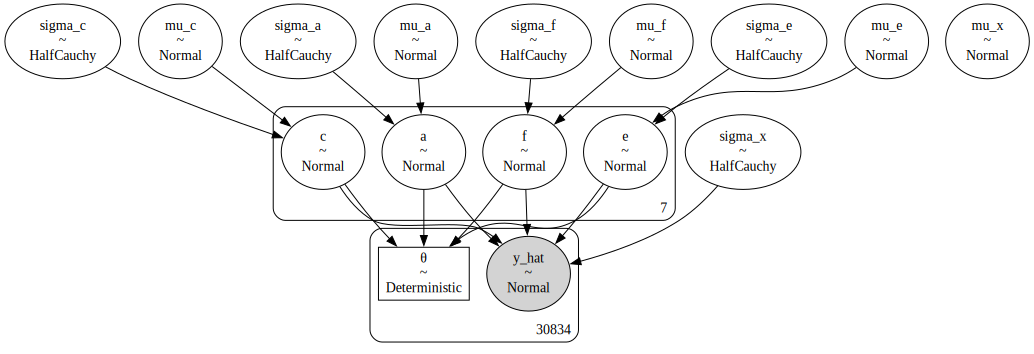

In [67]:
# Graph the hierarchical model
pm.model_to_graphviz(hierarchical_model)

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'e'}>,
        <AxesSubplot:title={'center':'e'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>]], dtype=object)

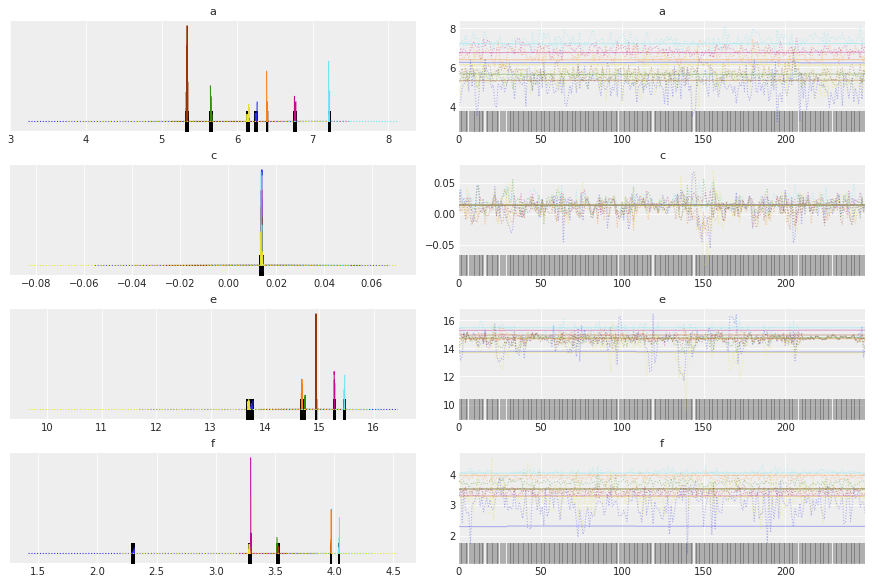

In [68]:
az.plot_trace(hierarchical_trace, var_names=['a', 'c', 'e', 'f'], compact =True)

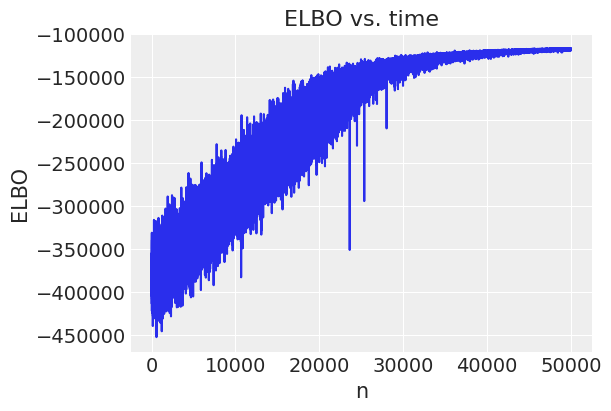

In [69]:
# plot the ELBO vs. fitting time or iterations (n)
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_hierarchical_fit.hist,
     'n': np.arange(advi_hierarchical_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()

Text(0.5, 1.0, 'Sampling 94% HDI')

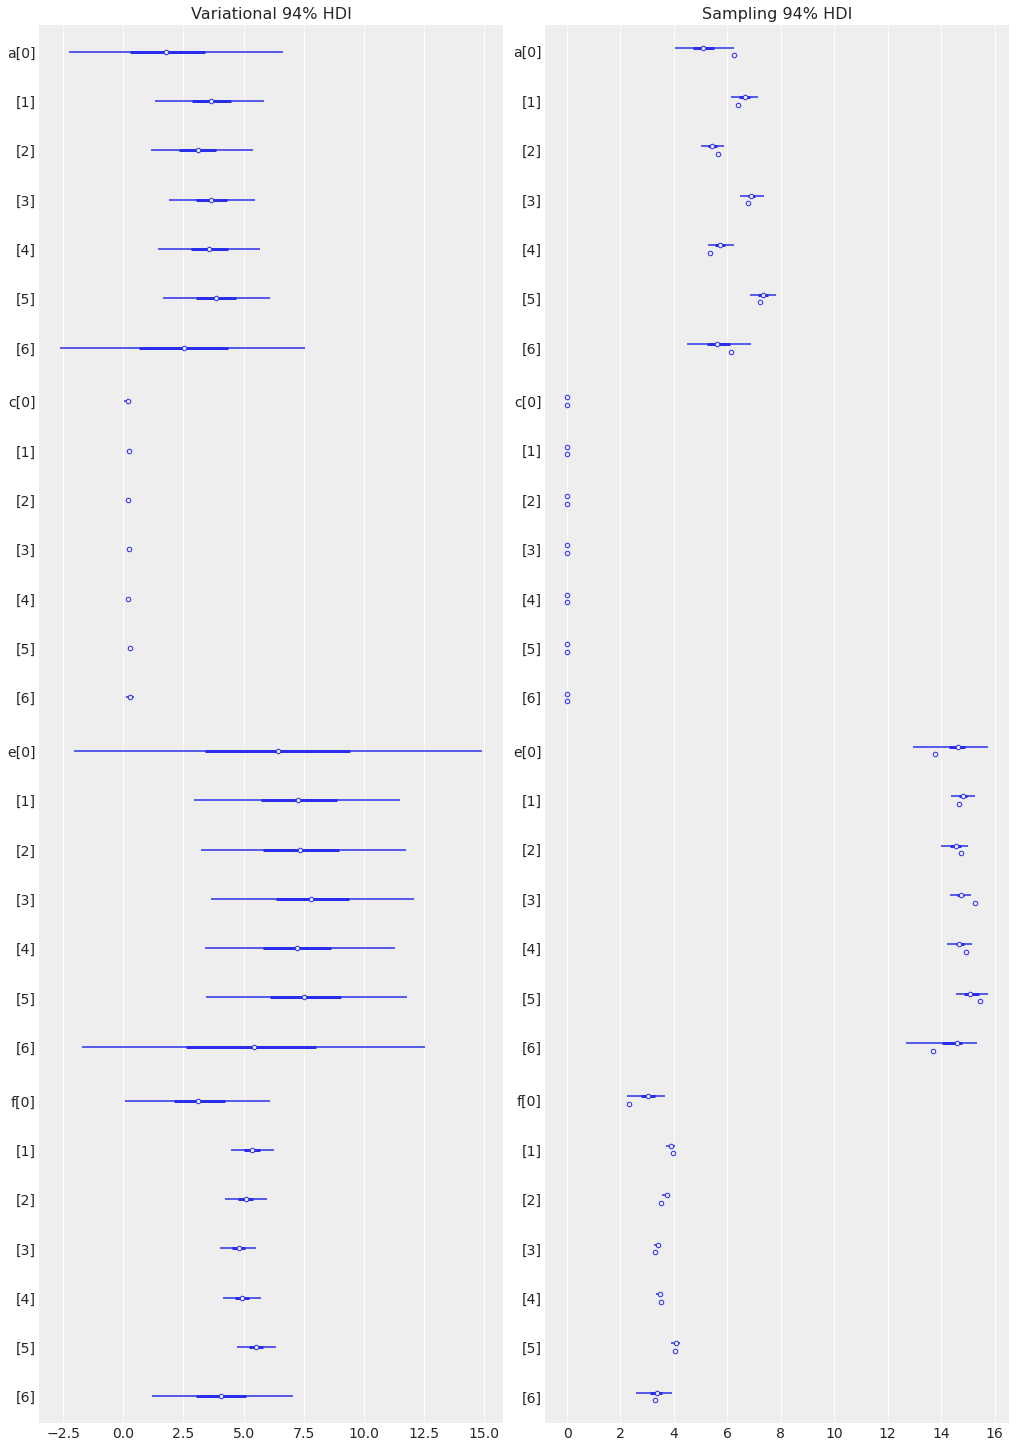

In [70]:
# sample from the variational posterior distribution
PPC_SAMPLES = 5000
advi_hierarchical_sample = advi_hierarchical_fit.sample(PPC_SAMPLES)

# Comparison of Variational and Sampling methods 
# Parameter posteriors in a forest plot

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (14,20))

pm.plot_forest(advi_hierarchical_sample, var_names=['a', 'c', 'e', 'f'], ax = ax1)
pm.plot_forest(hierarchical_trace, var_names=['a', 'c', 'e', 'f'], ax = ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')